In [1]:
import jax
from jax import random
import jax.numpy as jnp
from jax import jit, value_and_grad
from einops import rearrange
from tqdm import tqdm

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [23]:
image_size = 64
input_shape = (1, image_size, image_size)
input_height, input_width, input_channels = input_shape

kernel_size = 3
stride=1
padding=0

In [15]:

mean, std = [0.5], [0.5]


train_dataset = MNIST(
        root='data',
        download=True,
        transform=transforms.Compose([transforms.Resize((image_size,image_size)),  transforms.ToTensor(), transforms.Normalize(mean, std)])
)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)


test_dataset = MNIST(
        root='data',
        download=False,
        transform=transforms.Compose([transforms.Resize((image_size,image_size)), transforms.ToTensor(), transforms.Normalize(mean, std)])
)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

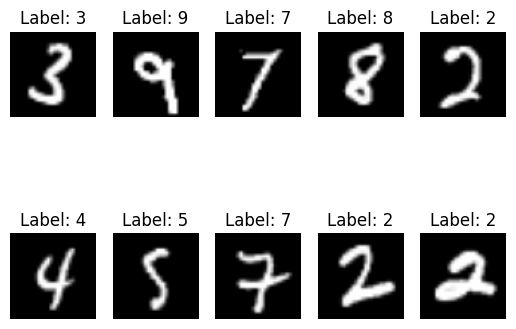

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Update mean and std for a single channel (grayscale)
mean, std = [0.5], [0.5]

# Get one batch of images and labels
for images, labels in train_loader:
    # Loop through the first 10 images in the batch
    for i in range(10):
        # Convert the image to a numpy array
        image = np.asarray(images[i])
        # Denormalize the image
        image = image * np.array(std) + np.array(mean)
        # Clip the values to be between 0 and 1
        image = np.clip(image, 0, 1)
        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(image[0], cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

In [50]:
def initialize_Conv2D(w_key, input_channels, kernel_size, num_kernels):
    # Calculate proper initialization scale
    fan_in = input_channels * kernel_size**2
    fan_out = num_kernels * kernel_size**2
    limit = jnp.sqrt(6.0 / (fan_in + fan_out))



    # Initialize kernels with correct dimensions [kernel_size, kernel_size, input_channels, num_kernels]
    kernels = random.uniform(
            w_key,
            (kernel_size, kernel_size, input_channels, num_kernels),
            minval=-limit,
            maxval=limit
    )

    # Initialize biases (one per kernel)
    biases = jnp.zeros(num_kernels)

    return kernels, biases

def Conv2D(params, inputs, kernel_size, stride, padding):
    kernels, biases = params

    # Get input dimensions
    input_height, input_width, _ = inputs.shape

    # Calculate output dimensions
    output_height = (input_height - kernel_size + 2 * padding) // stride + 1
    output_width = (input_width - kernel_size + 2 * padding) // stride + 1

    # Add padding to input
    padded_input = jnp.pad(
            inputs,
            ((padding, padding), (padding, padding), (0, 0)),
            mode='constant'
    )

    # Initialize output tensor
    output = jnp.zeros((output_height, output_width, kernels.shape[-1]))

    # Perform convolution
    for k in range(kernels.shape[-1]):  # Iterate over output channels
        kernel = kernels[..., k]  # Get current kernel [kernel_size, kernel_size, input_channels]
        bias = biases[k]

        for y in range(output_height):
            for x in range(output_width):
                # Calculate window position
                y_start = y * stride
                y_end = y_start + kernel_size
                x_start = x * stride
                x_end = x_start + kernel_size

                # Extract input region
                input_region = padded_input[y_start:y_end, x_start:x_end, :]

                # Compute convolution and add bias
                conv_val = jnp.sum(input_region * kernel) + bias
                output = output.at[y, x, k].set(conv_val)

    return output

In [82]:
# Set random seed for reproducibility
seed = 42
input_channels = 1  # RGB channels
kernel_size = 3
num_kernels = 16    # Number of output channels
stride = 1
padding = 1
num_classes = 10

# Create random input image (H, W, C format)
input_height = 64
input_width = 64
inputs = random.uniform(random.PRNGKey(0), (input_height, input_width, input_channels))

# Initialize convolution layer
conv_params = initialize_Conv2D(
        w_key=random.PRNGKey(0),
        input_channels=input_channels,
        kernel_size=kernel_size,
        num_kernels=num_kernels
)

# Perform convolution
output = Conv2D(
        params=conv_params,
        inputs=inputs,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding
)

print("Input shape:", inputs.shape)
print("Kernel shape:", conv_params[0].shape)
print("Output shape:", output.shape)

Input shape: (64, 64, 1)
Kernel shape: (3, 3, 1, 16)
Output shape: (64, 64, 16)


In [52]:
def avg_pool(input_data, window_shape=(2, 2), strides=(2, 2)):
    # Extract dimensions with channel support (H, W, C)
    input_height, input_width, num_channels = input_data.shape
    window_height, window_width = window_shape
    stride_height, stride_width = strides

    # Calculate output dimensions
    output_height = (input_height - window_height) // stride_height + 1
    output_width = (input_width - window_width) // stride_width + 1

    # Initialize output with the proper channel dimension
    output = jnp.zeros((output_height, output_width, num_channels))

    # Perform a pooling operation
    for y in range(output_height):
        for x in range(output_width):
            # Calculate window boundaries
            y_start = y * stride_height
            y_end = y_start + window_height
            x_start = x * stride_width
            x_end = x_start + window_width

            # Extract window with channel preservation
            window = input_data[y_start:y_end, x_start:x_end, :]

            # Calculate mean over spatial dimensions only (H, W)
            output = output.at[y, x, :].set(jnp.mean(window, axis=(0, 1)))

    return output

In [53]:
# Test 1: Simple 2x2 single-channel input
input_2x2 = jnp.ones((2, 2, 1))
output = avg_pool(input_2x2)
print("Test 1 (2x2 input):")
print(f"Input shape: {input_2x2.shape}, Output shape: {output.shape}")
print(f"Output values:\n{output.squeeze()}\n")

# Test 2: Multi-channel input
input_multi = jnp.ones((2, 2, 3)) * jnp.array([1, 2, 3])
output = avg_pool(input_multi)
print("Test 2 (Multi-channel):")
print(f"Output channel means: {output[0,0,:]}\n")

# Test 3: 4x4 input with pattern
input_4x4 = jnp.arange(16).reshape(4, 4, 1).astype(float)
output = avg_pool(input_4x4)
print("Test 3 (4x4 input):")
print("Input:")
print(input_4x4[:, :, 0])
print("\nOutput:")
print(output[:, :, 0])
print()

# Test 4: Non-square window and stride
input_5x5 = jnp.arange(25).reshape(5, 5, 1).astype(float)
output = avg_pool(input_5x5, window_shape=(3, 2), strides=(2, 1))
print("Test 4 (Non-square parameters):")
print(f"Output shape: {output.shape}")
print("First row values:")
print(output[0, :, 0].round(2))

Test 1 (2x2 input):
Input shape: (2, 2, 1), Output shape: (1, 1, 1)
Output values:
1.0

Test 2 (Multi-channel):
Output channel means: [1. 2. 3.]

Test 3 (4x4 input):
Input:
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]

Output:
[[ 2.5  4.5]
 [10.5 12.5]]

Test 4 (Non-square parameters):
Output shape: (2, 4, 1)
First row values:
[5.5 6.5 7.5 8.5]


In [54]:
# Dense Layer

def initialize_dense_layer(key, input_dim, output_dim):
    w_key, b_key = random.split(key)
    # Xavier uniform limit for W and b
    limit = jnp.sqrt(6.0/(input_dim + output_dim))

    # Xavier uniform initialization for weights and biases
    w = random.uniform(w_key, (input_dim, output_dim), minval=-limit, maxval=limit)
    b = random.uniform(b_key, (output_dim,), minval=-limit, maxval=limit)
    return w, b

def dense_layer(params, x):
    w, b = params
    return jnp.dot(x, w) + b

In [55]:
# initialize CNN parameters
cnn_parameters = {
    'conv1': None,
    'conv2':None,
    'dense1': None,
    'dense2': None,
}

In [59]:
def relu(input):
    return jnp.maximum(0, input)

In [66]:
# Initialize CNN parameters
key = random.PRNGKey(seed)
# Split the key into 4 keys
key, *subkeys = random.split(key, 5)

# Initialize Conv2D parameters
cnn_parameters['conv1'] = initialize_Conv2D(
    subkeys[0], input_channels=1, kernel_size=3, num_kernels=32
)
cnn_parameters['conv2'] = initialize_Conv2D(
    subkeys[1], input_channels=32, kernel_size=3, num_kernels=64
)

# Initialize Dense parameters
cnn_parameters['dense1'] = initialize_dense_layer(
    subkeys[2], input_dim=16384, output_dim=256
)
cnn_parameters['dense2'] = initialize_dense_layer(
    subkeys[3], input_dim=256, output_dim=10
)

In [67]:
cnn_parameters

{'conv1': (Array([[[[ 0.06130156,  0.10298502,  0.12773335, -0.12020013,
            -0.1106156 ,  0.05658929, -0.11158824,  0.00480411,
            -0.07413754, -0.09107427, -0.00965071, -0.1413933 ,
             0.07867394,  0.00460499,  0.02903989, -0.12259136,
             0.07537765,  0.11838994,  0.13455874,  0.0149634 ,
            -0.02369132,  0.11786553,  0.11510632, -0.05537548,
             0.11000025,  0.08896282, -0.1052632 , -0.11990894,
             0.08227593,  0.04579935,  0.08461778, -0.10708146]],
  
          [[-0.02075522,  0.1222046 ,  0.04091551, -0.01691751,
            -0.09923952, -0.08089976, -0.09553215,  0.12800737,
             0.07336596, -0.07390206,  0.09250624, -0.103805  ,
            -0.04804883, -0.03511525,  0.04099531, -0.09054081,
             0.09813304, -0.0787982 , -0.06124303,  0.02246341,
             0.08859317,  0.0025322 , -0.14015543,  0.04263834,
             0.06350237,  0.08941091, -0.04329016,  0.04354266,
            -0.07717463, -

In [70]:
def cnn(inputs, cnn_parameters):
    # Convert from (C, H, W) to (H, W, C) format
    x = jnp.transpose(inputs, (1, 2, 0))  # Now shape (64, 64, 1)

    # First Conv + Pool
    x = Conv2D(cnn_parameters['conv1'], x, kernel_size=3, stride=1, padding=1)
    x = avg_pool(x, window_shape=(2, 2), strides=(2, 2))  # Shape: (32, 32, 32)

    # Second Conv + Pool
    x = Conv2D(cnn_parameters['conv2'], x, kernel_size=3, stride=1, padding=1)
    x = avg_pool(x, window_shape=(2, 2), strides=(2, 2))  # Shape: (16, 16, 64)

    # Flatten
    x = jnp.reshape(x, (-1,))  # Flatten to 16*16*64 = 16384

    # Dense layers
    x = dense_layer(cnn_parameters['dense1'], x)
    x = relu(x)
    x = dense_layer(cnn_parameters['dense2'], x)
    return x

# Create input with shape (1, 64, 64) - single channel image
sample_image = random.normal(key, (1, 64, 64))
prediction = cnn(sample_image, cnn_parameters)
print("Output shape:", prediction.shape)  # Should be (10,)

Output shape: (10,)


In [72]:
bsize = 5
sample_images = random.normal(key, (bsize, 1 ,image_size, image_size))

In [74]:
prediction = jax.vmap(cnn, in_axes=(0, None))(sample_images, cnn_parameters)
print("Prediction shape:", prediction.shape)

Prediction shape: (5, 10)


In [75]:
prediction

Array([[ 0.06300314, -0.13689339, -0.09618019,  0.13940765, -0.15108728,
        -0.02049428, -0.18256702, -0.13774398, -0.15728512,  0.16696817],
       [ 0.06949523, -0.10611115, -0.01768159,  0.2602982 , -0.15013933,
        -0.01712194, -0.05784557, -0.08824317, -0.10435341,  0.18948108],
       [ 0.09368565, -0.28859285, -0.12639308,  0.2112851 , -0.1674474 ,
        -0.00157769, -0.19603825, -0.00172266, -0.08839975,  0.16473508],
       [ 0.1125599 , -0.02666707, -0.02286467,  0.31277615, -0.09003498,
        -0.00434129, -0.24882188, -0.05858929, -0.21998994,  0.26691622],
       [ 0.14185406, -0.24348706, -0.08909795,  0.2519405 , -0.08942879,
        -0.04097011, -0.12651388, -0.10828628, -0.08414801,  0.14673084]],      dtype=float32)

In [78]:
def cross_entropy_loss(patches, cnn_parameters, ground_truth):
    prediction = jax.vmap(cnn, in_axes=(0, None))(patches, cnn_parameters)
    logs = jax.nn.log_softmax(prediction)
    l = -jnp.mean(jnp.sum(ground_truth * logs, axis=-1))
    return l

In [77]:
l = cross_entropy_loss(sample_images, cnn_parameters, jnp.zeros((bsize, 10)).at[0, 1].set(1))
print("Loss:", l)

Loss: 0.4792119


In [79]:
from jax import value_and_grad

# fake labels and images
sample_images = random.normal(key, (bsize, 3 ,image_size, image_size))
sample_target = jnp.zeros((bsize, 10)).at[0, 1].set(1)
current_loss, grads = value_and_grad(cross_entropy_loss, argnums=1)(sample_images, cnn_parameters, sample_target)

print("Current loss:", current_loss)
print("Gradients:", grads.keys())

Current loss: 0.50334865
Gradients: dict_keys(['conv1', 'conv2', 'dense1', 'dense2'])


In [81]:
from jax import jit, value_and_grad

@jit
def train_step(patches, cnn_parameters, target):
    # compute gradients
    current_loss, grads = value_and_grad(cross_entropy_loss, argnums=1)(
            patches,
            cnn_parameters,
            target)

    # update parameters
    updated_params = jax.tree.map(lambda p, g: p - 0.01 * g, cnn_parameters, grads)

    return current_loss, updated_params

In [ ]:
import jax
from jax import value_and_grad
from jax import jit
from tqdm import tqdm

num_epochs = 20


for epoch in range(num_epochs):

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    #for (data, target) in tqdm(train_loader, desc=f'Train epoch {epoch}'):
    for i, (data, target) in progress_bar:

        # convert to numpy
        data = jnp.asarray(data)
        target = jnp.asarray(target)

        # reshape and get one hot fot loss
        target_one_hot = jax.nn.one_hot(target, num_classes)

        current_loss, vit_parameters = train_step(data, cnn_parameters, target_one_hot)

        progress_bar.set_postfix({'loss': current_loss})


    eval_acc = eval(cnn_parameters)
    print(f'Epoch: {epoch}, Eval acc: {eval_acc}')

Epoch 1/20:   0%|          | 0/235 [00:00<?, ?it/s]